# Spatial distribution of altimeter along-track data

## Goal of the Notebook

This notebook aims at studying the spatial distribution of altimeter along-track data within a 20-day window centered on 29 May. 

## Data

To download the data see the README.md. The user will need to define the paths of the data directories of the folder(s) which holds the data.

## Import moduls and open datasets

In [1]:
### IMPORT MODULES ###

import os, sys
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import julian
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in intersects")

In [2]:
### CONVENTIONAL ALTIMETRY L4 ###
datadir_convalt_l4 = '/Users/martina/ex_tesi/Notebooks/'
ds_convalt_l4 = xr.open_dataset(datadir_convalt_l4+'cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.0625deg_P1D_multi-vars_0.03E-4.97E_36.03N-39.97N_2023-05-01-2023-06-19.nc')
sla_conv_alt = ds_convalt_l4['sla'].sel(longitude=slice(0,6), latitude=slice(36,40))

In [3]:
### CONVENTIONAL ALTIMETRY L3 ###

datadir_convalt_l3 = '/Users/martina/ex_tesi/datasets/tracks/6week_window/'

## Paths to CSV files from different satellites ##
file_path1 = datadir_convalt_l3 + 'cmems_obs-sl_eur_phy-ssh_my_s6a-lr-l3-duacs_PT1S_1745841298675.csv'
file_path2 = datadir_convalt_l3 + 'cmems_obs-sl_eur_phy-ssh_my_s3b-l3-duacs_PT1S_1745841270578.csv' 
file_path3 = datadir_convalt_l3 + 'cmems_obs-sl_eur_phy-ssh_my_s3a-l3-duacs_PT1S_1745841244538.csv' 
file_path4 = datadir_convalt_l3 + 'cmems_obs-sl_eur_phy-ssh_my_alg-l3-duacs_PT1S_1745841210301.csv' 
file_path5 = datadir_convalt_l3 + 'cmems_obs-sl_eur_phy-ssh_my_j3n-l3-duacs_PT1S_1745841160754.csv' 
file_path6 = datadir_convalt_l3 + 'cmems_obs-sl_eur_phy-ssh_my_h2b-l3-duacs_PT1S_1745841043444.csv' 
file_path7 = datadir_convalt_l3 + 'cmems_obs-sl_eur_phy-ssh_my_c2n-l3-duacs_PT1S_1745841085230.csv' 

## Open and read CSV files ##
with open(file_path1, 'r') as f:
    lines = f.readlines()

skiprows = sum(1 for line in lines if line.startswith("#"))

df_s6a = pd.read_csv(file_path1, delimiter=',', skiprows=skiprows)

df_s3b = pd.read_csv(file_path2, delimiter=',', skiprows=skiprows)

df_s3a = pd.read_csv(file_path3, delimiter=',', skiprows=skiprows)

df_al = pd.read_csv(file_path4, delimiter=',', skiprows=skiprows)

df_j3n = pd.read_csv(file_path5, delimiter=',', skiprows=skiprows)

df_h2b = pd.read_csv(file_path6, delimiter=',', skiprows=skiprows)

df_c2n = pd.read_csv(file_path7, delimiter=',', skiprows=skiprows)

## Preprocessing of the datasets

### Cut the altimetry L3 dataset to the area of interest

In [4]:
## Spatial limits ##
lon_min = 1.85
lon_max = 4.5
lat_max = 38

## Apply longitude filter to all satellites ##
df_s6a = df_s6a[(df_s6a['longitude'] >= lon_min) & (df_s6a['longitude'] <= lon_max)]
df_s3b = df_s3b[(df_s3b['longitude'] >= lon_min) & (df_s3b['longitude'] <= lon_max)]
df_s3a = df_s3a[(df_s3a['longitude'] >= lon_min) & (df_s3a['longitude'] <= lon_max)]
df_al = df_al[(df_al['longitude'] >= lon_min) & (df_al['longitude'] <= lon_max)]
df_j3n = df_j3n[(df_j3n['longitude'] >= lon_min) & (df_j3n['longitude'] <= lon_max)]
df_h2b = df_h2b[(df_h2b['longitude'] >= lon_min) & (df_h2b['longitude'] <= lon_max)]
df_c2n = df_c2n[(df_c2n['longitude'] >= lon_min) & (df_c2n['longitude'] <= lon_max)]

## Apply latitude filter (upper boundary only) ##
df_s6a = df_s6a[(df_s6a['latitude'] <= lat_max)]
df_s3b = df_s3b[(df_s3b['latitude'] <= lat_max)]
df_s3a = df_s3a[(df_s3a['latitude'] <= lat_max)]
df_al = df_al[(df_al['latitude'] <= lat_max)]
df_j3n = df_j3n[(df_j3n['latitude'] <= lat_max)]
df_h2b = df_h2b[(df_h2b['latitude'] <= lat_max)]
df_c2n = df_c2n[(df_c2n['latitude'] <= lat_max)]

### Cut the altimetry L3 dataset to the period of interest

In [5]:
## Convert "time" column to datetime and extract date (YYYY-MM-DD only) ##

df_c2n['time'] = pd.to_datetime(df_c2n['time'])
df_c2n['date'] = df_c2n['time'].dt.date  

df_h2b['time'] = pd.to_datetime(df_h2b['time'])
df_h2b['date'] = df_h2b['time'].dt.date  

df_j3n['time'] = pd.to_datetime(df_j3n['time'])
df_j3n['date'] = df_j3n['time'].dt.date  

df_al['time'] = pd.to_datetime(df_al['time'])
df_al['date'] = df_al['time'].dt.date  

df_s3a['time'] = pd.to_datetime(df_s3a['time'])
df_s3a['date'] = df_s3a['time'].dt.date 

df_s3b['time'] = pd.to_datetime(df_s3b['time'])
df_s3b['date'] = df_s3b['time'].dt.date  

df_s6a['time'] = pd.to_datetime(df_s6a['time'])
df_s6a['date'] = df_s6a['time'].dt.date  

In [6]:
## Select the time window of interest ##
start_date = datetime(2023, 5, 19) 
end_date = datetime(2023, 6, 8)

df_s6a = df_s6a[(df_s6a['date'] >= start_date.date()) & (df_s6a['date'] <= end_date.date())]
df_s3b = df_s3b[(df_s3b['date'] >= start_date.date()) & (df_s3b['date'] <= end_date.date())]
df_s3a = df_s3a[(df_s3a['date'] >= start_date.date()) & (df_s3a['date'] <= end_date.date())]
df_al = df_al[(df_al['date'] >= start_date.date()) & (df_al['date'] <= end_date.date())]
df_j3n = df_j3n[(df_j3n['date'] >= start_date.date()) & (df_j3n['date'] <= end_date.date())]
df_h2b = df_h2b[(df_h2b['date'] >= start_date.date()) & (df_h2b['date'] <= end_date.date())]
df_c2n = df_c2n[(df_c2n['date'] >= start_date.date()) & (df_c2n['date'] <= end_date.date())]

In [7]:
## Compute Julian day (day of the year) for each dataset ##

df_s6a['date'] = pd.to_datetime(df_s6a['date'])
df_s3b['date'] = pd.to_datetime(df_s3b['date'])
df_s3a['date'] = pd.to_datetime(df_s3a['date'])
df_al['date'] = pd.to_datetime(df_al['date'])
df_j3n['date'] = pd.to_datetime(df_j3n['date'])
df_h2b['date'] = pd.to_datetime(df_h2b['date'])
df_c2n['date'] = pd.to_datetime(df_c2n['date'])

df_s6a['julian_day'] = df_s6a['date'].dt.dayofyear
df_s3b['julian_day'] = df_s3b['date'].dt.dayofyear
df_s3a['julian_day'] = df_s3a['date'].dt.dayofyear
df_al['julian_day'] = df_al['date'].dt.dayofyear
df_j3n['julian_day'] = df_j3n['date'].dt.dayofyear
df_h2b['julian_day'] = df_h2b['date'].dt.dayofyear
df_c2n['julian_day'] = df_c2n['date'].dt.dayofyear


## Figure: spatial distribution of the tracks

In [8]:
### Customized colormap ###

# Define the range of “offset days” around May 29 (–10 to +10)
day_range = np.arange(-10, 11)       
# Number of colors needed for the colormap
n_colors = len(day_range)    

## Function to create a symmetric colormap with a dark center ##
def make_center_dark_colormap(n):
    
    assert n % 2 == 1, "n must be odd" # Ensure that n is odd so that there is only ONE central color
    half = n // 2
    steps = np.linspace(0.3, 1, half)
    left = cm.afmhot(steps[::-1])
    right = cm.afmhot(steps)
    center = np.array([[0.05, 0.05, 0.05, 1]])  
    return ListedColormap(np.vstack([left, center, right]))

custom_cmap = make_center_dark_colormap(n_colors)
# Boundaries for discretizing the colormap
boundaries = np.arange(-10.5, 10.6, 1)  
# Normalization to match the boundaries
norm = BoundaryNorm(boundaries, ncolors=n_colors)

In [9]:
### Function to plot the tracks ###

def plot_tracks(df):
    # Loop through the dataset grouped by date
    for date, group in df.groupby('date'):
        lon = group['longitude']
        lat = group['latitude']
        # Compute the day offset relative to Julian day 156 (May 29)
        offset_days = group['julian_day'] - 156
        # Plot the track points colored by offset days
        ax.scatter(lon, lat, c=offset_days, s=30, alpha=0.9, edgecolors='k',
                   linewidths=0.2, cmap=custom_cmap, norm=norm, transform=ccrs.PlateCarree())

In [10]:
## Cut the L4 altimetry dataset so it shows only the contour of interest ## 
sla_529 = sla_conv_alt[28,:,:].where((sla_conv_alt[28,:,:]['longitude'] > 2.5) & (sla_conv_alt[28,:,:]['longitude'] < 4))

## Contour for the eddy on may 29, identified by pyeddytracker (PET) algorithm  ##
lev_pet = 0.105

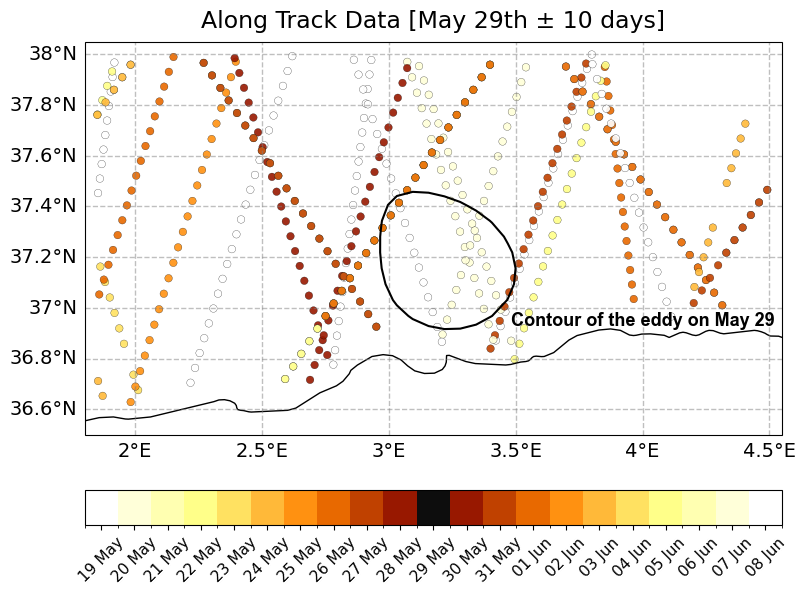

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 9))
ax.coastlines(resolution='10m', color='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
gl.right_labels = False
gl.top_labels = False

ax.set_title('Along Track Data [May 29th ± 10 days]', fontsize=17, pad=10)
ax.contour(sla_529['longitude'], sla_529['latitude'], sla_529, levels=[lev_pet], colors='k')
ax.text(4.52, 36.915, 'Contour of the eddy on May 29', fontsize=13, ha='right', va='bottom',
        color='k', alpha=1, fontweight='semibold', fontname='Arial')

for df in [df_c2n, df_h2b, df_j3n, df_al, df_s3a, df_s3b, df_s6a]:
    plot_tracks(df)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm),
    ax=ax, orientation='horizontal', pad=0.08, spacing='uniform'
)
cbar.set_ticks(day_range)
cbar.set_ticklabels([(datetime(2023, 5, 29) + timedelta(days=int(d))).strftime('%d %b') for d in day_range], rotation=45)
cbar.ax.tick_params(labelsize=11)

ax.set_extent([1.8, 4.55, 36.5, 38.05], crs=ccrs.PlateCarree())

plt.show()